In [1]:
import matplotlib.pyplot as plt
import numpy as np

from dosipy.constants import eps_0
from dosipy.utils.dataloader import load_tissue_diel_properties
from dosipy.utils.integrate import elementwise_quad, elementwise_rectquad

from utils import reflection_coefficient

In [2]:
# working frequency, Hz
f = 100e9

# peak incident power density, W/m2
ipd = 100

# dry skin density, kg/m3
rho = 1109

# conductivity, relative permitivitya and penetration depth
sigma, eps_r, _, pen_depth = load_tissue_diel_properties('skin_dry', f)
L = pen_depth / 2  # energy penetration depth in m

# reflection coefficient
eps_i = sigma / (2 * np.pi * f * eps_0)
eps = eps_r - 1j * eps_i
gamma = reflection_coefficient(eps)

# power transmission coefficient
T_tr = 1 - gamma ** 2

In [3]:
# control volume
target_area = (0.02, 0.02)  # meters x meters
A = target_area[0] * target_area[1]  # meters^2
x = np.linspace(-target_area[0]/2, target_area[0]/2)
y = np.linspace(-target_area[1]/2, target_area[1]/2)
z = np.linspace(0, 0.02)
bbox = [x.min(), x.max(), y.min(), y.max()]

In [4]:
# compute sar
R0 = 0.007  # in m
X, Y = np.meshgrid(x, y)
r = np.sqrt(X ** 2 + Y ** 2)
sar_surf = ipd * T_tr / (rho * L) * np.exp(-r / R0)
sar = np.outer(
    sar_surf, np.exp(-z / L)
).reshape(*sar_surf.shape, *z.shape)

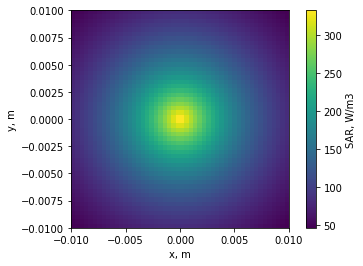

In [5]:
cm = plt.imshow(sar_surf, extent=bbox, origin='lower')
bar = plt.colorbar(cm, label='SAR, W/m3')
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.show()

In [6]:
# compute tpd
tpd_surf = np.zeros_like(sar_surf)
for i in range(sar_surf.shape[0]):
    for j in range(sar_surf.shape[1]):
        tpd_surf[i, j] = elementwise_quad(z, sigma * sar[i, j, :], degree=21)
tpd = elementwise_rectquad(x, y, tpd_surf) / A

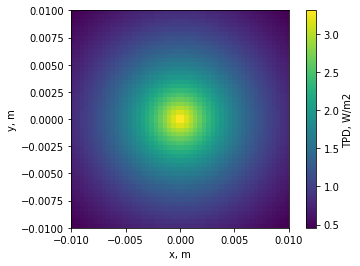

In [7]:
cm = plt.imshow(tpd_surf, extent=bbox, origin='lower')
bar = plt.colorbar(cm, label='TPD, W/m2')
plt.xlabel('x, m')
plt.ylabel('y, m')
plt.show()